In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from IPython import display

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


In [2]:
# Load and preprocess the MNIST dataset
def load_data():
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    # Normalize the images to [-1, 1]
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5
    return train_images

train_images = load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# Define training parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Seed for generating images
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])


In [4]:
# Build the Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

generator = build_generator()


c:\Users\rover\Downloads\IA-Post-TUIA\GAN\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


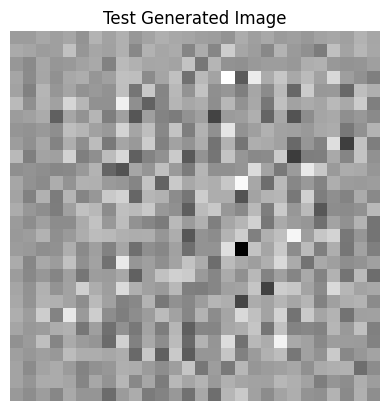

In [5]:
# Test the Generator
def test_generator():
    noise = tf.random.normal([1, NOISE_DIM])
    generated_image = generator(noise, training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.title("Test Generated Image")
    plt.axis('off')
    plt.show()

test_generator()


In [6]:
# Build the Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

discriminator = build_discriminator()


c:\Users\rover\Downloads\IA-Post-TUIA\GAN\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Test the Discriminator
def test_discriminator():
    decision = discriminator(generator(tf.random.normal([1, NOISE_DIM]), training=False))
    print("Discriminator output:", decision)

test_discriminator()


Discriminator output: tf.Tensor([[-0.00321396]], shape=(1, 1), dtype=float32)


In [8]:
# Define the loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real labels are 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake labels are 0
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Fool the discriminator

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [9]:
# Define the training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [10]:
# Function to generate and save images during training
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [11]:
# Define the training function
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


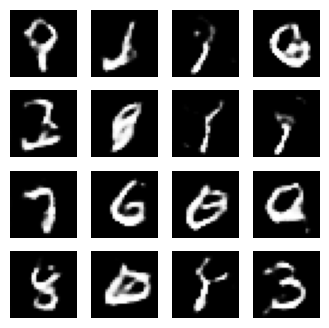

In [12]:
# Start training
train(train_dataset, EPOCHS)


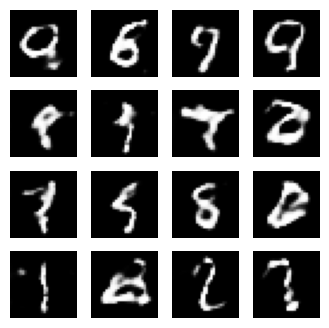

In [13]:
# Generate and display images after training
def display_generated_images():
    noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])
    generated_images = generator(noise, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.show()

display_generated_images()


In [14]:
# Save the generator model
generator.save('generator_model.h5')
print("Generator model saved.")


Generator model saved.


In [15]:
# Load the generator model
def load_generator_model():
    loaded_generator = tf.keras.models.load_model('generator_model.h5')
    return loaded_generator

loaded_generator = load_generator_model()
print("Generator model loaded.")


Generator model loaded.


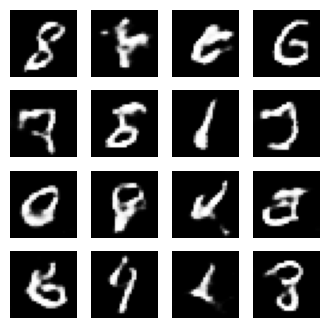

In [16]:
# Generate new images using the loaded model
def generate_new_images(model):
    new_noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])
    new_generated_images = model(new_noise, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(new_generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(new_generated_images[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.show()

generate_new_images(loaded_generator)
